In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

1.13.1
sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 1.13.1
tensorflow._api.v1.keras 2.2.4-tf


In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './cifar10/trainLabels.csv'
test_csv_file = './cifar10/sampleSubmission.csv'
train_folder = './cifar10/train/'
test_folder = './cifar10/test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('./cifar10/train/1.png', 'frog'),
 ('./cifar10/train/2.png', 'truck'),
 ('./cifar10/train/3.png', 'truck'),
 ('./cifar10/train/4.png', 'deer'),
 ('./cifar10/train/5.png', 'automobile')]
[('./cifar10/test/1.png', 'cat'),
 ('./cifar10/test/2.png', 'cat'),
 ('./cifar10/test/3.png', 'cat'),
 ('./cifar10/test/4.png', 'cat'),
 ('./cifar10/test/5.png', 'cat')]
50000 300000


In [3]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                filepath       class
0  ./cifar10/train/1.png        frog
1  ./cifar10/train/2.png       truck
2  ./cifar10/train/3.png       truck
3  ./cifar10/train/4.png        deer
4  ./cifar10/train/5.png  automobile
                    filepath       class
0  ./cifar10/train/45001.png       horse
1  ./cifar10/train/45002.png  automobile
2  ./cifar10/train/45003.png        deer
3  ./cifar10/train/45004.png  automobile
4  ./cifar10/train/45005.png    airplane
               filepath class
0  ./cifar10/test/1.png   cat
1  ./cifar10/test/2.png   cat
2  ./cifar10/test/3.png   cat
3  ./cifar10/test/4.png   cat
4  ./cifar10/test/5.png   cat


In [4]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
45000 5000


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batc

In [7]:
epochs = 20
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Epoch 1/20
1407/1407 [==============================] - 631s 449ms/step - loss: 2.5543 - acc: 0.2675 - val_loss: 1.6870 - val_acc: 0.3806
Epoch 2/20
1407/1407 [==============================] - 91s 65ms/step - loss: 1.7151 - acc: 0.3767 - val_loss: 1.7154 - val_acc: 0.4232
Epoch 3/20
1407/1407 [==============================] - 91s 65ms/step - loss: 1.5059 - acc: 0.4543 - val_loss: 1.7433 - val_acc: 0.4360
Epoch 4/20
1407/1407 [==============================] - 91s 65ms/step - loss: 1.3400 - acc: 0.5198 - val_loss: 1.1556 - val_acc: 0.6002
Epoch 5/20
1407/1407 [==============================] - 91s 65ms/step - loss: 1.1878 - acc: 0.5788 - val_loss: 1.0857 - val_acc: 0.6226
Epoch 6/20
1407/1407 [==============================] - 91s 65ms/step - loss: 1.0565 - acc: 0.6303 - val_loss: 1.0947 - val_acc: 0.6430
Epoch 7/20
1407/1407 [==============================] - 91s 65ms/step - loss: 0.9525 - acc: 0.6676 - val_loss: 0.7530 - val_acc: 0.7496
Epoch 8/20
1407/1407 [========================

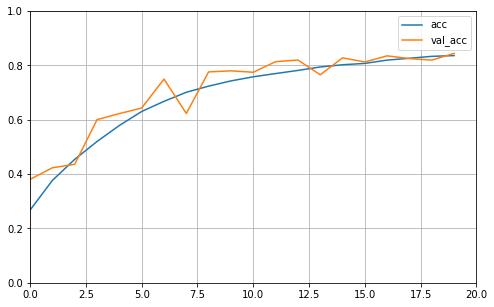

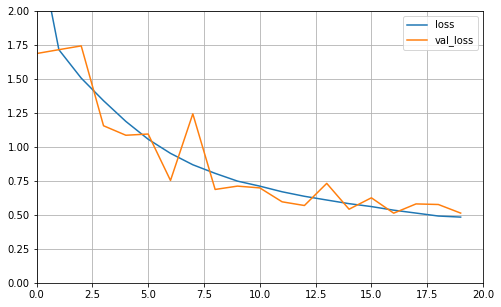

In [8]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'acc', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [9]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 images belonging to 10 classes.
300000


In [10]:
test_predict = model.predict_generator(test_generator,
                                       workers = 10,
                                       use_multiprocessing = True)

In [11]:
print(test_predict.shape)

(300000, 10)


In [12]:
print(test_predict[0:5])

[[1.8115582e-02 3.0195517e-02 9.7707666e-02 2.2199485e-01 9.6216276e-02
  1.4796969e-02 3.6596778e-01 2.3226894e-02 1.2524511e-02 1.1925392e-01]
 [9.3144512e-01 2.5595291e-04 3.6763612e-02 9.3153082e-03 9.9368917e-04
  9.1112546e-05 1.5013785e-02 3.5342187e-04 5.2798474e-03 4.8821873e-04]
 [7.2171527e-04 8.8273185e-01 3.1592429e-06 1.9850962e-05 2.2674351e-06
  1.8648565e-06 1.6326395e-06 1.5337924e-05 6.6775086e-05 1.1643546e-01]
 [1.7911234e-05 7.6694396e-06 7.3977681e-06 1.4877276e-06 1.0498322e-06
  2.0850619e-07 1.4016325e-06 4.9560447e-07 9.9995601e-01 6.3446323e-06]
 [9.0831274e-01 1.8281976e-04 6.2809147e-02 1.6991662e-02 8.5249258e-04
  4.1505805e-04 3.8536564e-03 6.0711574e-04 5.2569183e-03 7.1851560e-04]]


In [13]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [14]:
print(test_predict_class_indices[0:5])

[6 0 1 8 0]


In [15]:
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]

In [16]:
print(test_predict_class[0:5])

['frog', 'airplane', 'automobile', 'ship', 'airplane']


In [17]:
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./cifar10/submission.csv"
generate_submissions(output_file, test_predict_class)